In [1]:
## NN Classification Problem

# Data: using make_circles() to generate two circles with different colored dots

from sklearn.datasets import make_circles

nSamples = 1000  # Number of samples
X, y = make_circles(nSamples, noise=0.03, random_state=42)

In [2]:
print(f"First five X features:\n{X[:5]}")
print(f"\nFirst five y labels:\n{y[:5]}")

First five X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First five y labels:
[1 1 1 1 0]


In [3]:
# Putting the data in the dataframe
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [4]:
# Checking the labels
circles.label.value_counts()

1    500
0    500
Name: label, dtype: int64

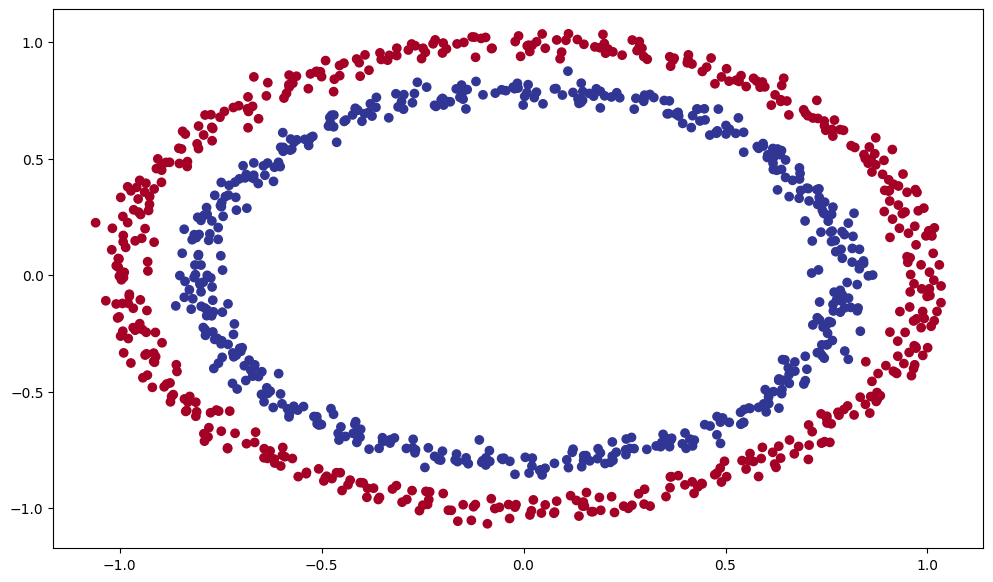

In [5]:
# Visualizing data

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 7))
plt.scatter(x=X[:, 0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu);

## Now there is a problem to solve
Building a model to classify dots in `red(0)` or `blue(1)`

In [6]:
# Checking the array shapes
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
# Turning data into tensors

import torch
print(f"Torch Version: {torch.__version__}")

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

print(f"\nFirst five rows of X:\n{X[:5]}")
print(f"First five rows of y:\n{y[:5]}")

Torch Version: 2.0.1+cu118

First five rows of X:
tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        [-0.3937,  0.6929],
        [ 0.4422, -0.8967]])
First five rows of y:
tensor([1., 1., 1., 1., 0.])


In [10]:
# Test/Train Split
from sklearn.model_selection import train_test_split

XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=42)

len(XTrain), len(yTrain), len(XTest), len(yTest)

(800, 800, 200, 200)

In [11]:
# Building a model

from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device in use: {device}")

Device in use: cpu


In [12]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=2, out_features=5)
    self.layer2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer2(self.layer1(x))

model0 = CircleModelV0()
model0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# Creating a loss function and optimizer

lossFn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model0.parameters(), lr=0.1)